In [39]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

# Дерево решений

Метод основан на известной структуре данных - деревьях, которые по сути представляют собой последовательные инструкции с условиями.
В листьях (терминальных узлах) деревьев стоят значения целевой функции (прогноз), а в узлах - условия перехода, определяющие, по какому из ребер идти. Если речь идет о бинарных деревьях (каждый узел производит ветвление на две части), обычно, если условие в узле истинно, то происходит переход по левому ребру, если ложно, то по правому. Изобразим описанный выше алгоритм в виде дерева решений.

![title](decision_tree.png)

Чаще всего в вершинах прописываются максимально простые условия. Обычно это сравнение значения одного из признаков $x^{j}$ с некоторым заданным порогом $t$:

$$[x^{j} \leq t].$$

Если решается задача классификации, конечным прогнозом является класс или распределение вероятностей классов. В случае регрессии прогноз в листе является вещественным числом.

Большим плюсом деревьев является тот факт, что они легко интерпретируемы. 

### 1. Построение дерева решений

Деревья обладают и отрицательными качествами - в частности, они очень легко переобучаются. Легко построить дерево, в котором каждый лист будет соответствовать одному объекту обучающей выборки. Оно будет идеально подогнано под обучающую выборку, давать стопроцентный ответ на ней, но при этом не будет восстанавливать оригинальных закономерностей, и качество ответов на новых данных будет неудовлетворительным.

Деревья строятся последовательно от корня к листьям (так называемый "жадный" способ). Вначале выбирается корень и критерий, по которому выборка разбивается на две. Затем то же самое делается для каждого из потомков этого корня и так далее до достаточного уровня ветвления. Задача состоит в выборе способа разбиения каждого из узлов, то есть в выборе значения порога, с которым будет сравниваться значение одного из признаков в каждом узле.

Разбиение выбирается с точки зрения некоторого заранее заданного функционала качества $Q(X, j, t)$. Находятся наилучшие значения $j$ и $t$ для создания _предиката_ $[x^{j}<t]$. Параметры $j$ и $t$ можно выбирать перебором: признаков конечное число, а из всех возможных значений порога $t$ можно рассматривать только те, при которых получаются различные разбиения на две подвыборки, таким образом, различных значений параметра $t$ будет столько же, сколько различных значений признака $x^{j}$ в обучающей выборке.

В каждой вершине производится проверка, не выполнилось ли некоторое условие останова (критерии останова рассмотрим далее), и если оно выполнилось, разбиение прекращается, и вершина объвляется листом, и он будет содержать прогноз.

В задаче классификации это будет класс, к которому относится большая часть объектов из выборки в листе $X_{m}$

$$a_{m} = \text{argmax}_{y \in Y} \sum_{i \in X_{m}}[y_{i}=y]$$

или доля объектов определенного класса $k$, если требуется предсказать вероятности классов

$$a_{mk} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}[y_{i}=k].$$

В случае регрессии можно в качестве ответа давать средний по выборке в листе

$$a_{m} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}y_{i}.$$

После построения дерева может проводиться его _стрижка_ (pruning) - удаление некоторых вершин согласно некоторому подходу с целью понижения сложности модели и повышения обобщающей способности.

За функционал качества при работе с деревом решений принимается функционал вида

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - _критерий информативности_. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в $X$, соответственно, задача обучения состоит в его минимизации и, соответственно, максимизации $Q(X_{m}, j, t)$ на данном шаге. Последний, по сути, характеризует прирост качества на данном шаге.

В формуле значения критериев информативности нормируются - домножаются на долю объектов, ушедших в соответствующее подмножество. Например, если у нас множество в узле разбилось на два подмножества размером в 9990 объектов и 10 объектов, но при этом в первом подмножестве все объекты будут принадлежать к одному классу (то есть иметь минимальное значение разброса), а во втором - к разным, то в целом разбиение будет считаться хорошим, так как подавляющее большинство отсортировано правильно.

### 2. Критерий информативности

В случае регрессии разброс будет характеризоваться дисперсией, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

В задаче классификации есть несколько способов определить критерий информативности.

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

_Критерий Джини_ или _индекс Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}),$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

Еще один критерий информативности - _энтропийный критерий_. Он также называется _энтропией Шеннона_ и записывается как

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$

### 3. Критерии останова

Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева. Этот критерий считается достаточно грубым, но хорошо зарекомендовавшим себя в построении композиций деревьев - когда несколько деревьев объединяются в один алгоритм.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе. При этом оно должно быть достаточным, чтобы построить надежный прогноз.


- Останов в случае, когда все объекты в листе относятся к одному классу.


- Требование улучшения функционала качества при разбиении на какую-то минимальную величину.

Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

### 4. Обрезка дерева

В случае применения метода стрижки (обрезки, прунинга) деревьев использовать критерии останова необязательно, и можно строить переобученные деревья, затем снижая их сложность, удаляя листья по некоторому критерию (например, пока улучшается качество на отложенной выборке). Считается, что стрижка работает лучше, чем критерии останова.

Одним из методов стрижки является _cost-complexity pruning_. Допустим, мы построили дерево, обозначенное как $T_{0}$. В каждом из листьев находятся объекты одного класса, и значение функционала ошибки $R(T)$ при этом будет минимально на $T_{0}$. Для борьбы с переобучением к нему добавляют "штраф" за размер дерева (аналогично регуляризации, рассмотренной нами в предыдущих уроках) и получают новый функционал $R_{\alpha}(T)$:

$$R_{\alpha}(T) = R(T) + \alpha|T|,$$

где $|T|$ - число листьев в дереве, $\alpha$ - некоторый параметр регуляризации. Таким образом если при построении дерева на каком-то этапе построения алгоритма ошибка будет неизменна, а глубина дерева увеличиваться, итоговый функционал, состоящий из их суммы, будет расти.

Однако стрижка деревьев обладает существенными минусами. В частности, она является очень трудоемкой процедурой. Например, она может требовать вычисления функционала качества на валидационной выборке на каждом шаге. К тому же, на данный момент одиночные деревья на практике почти не используются, а используются композиции деревьев, и в этом случае стрижка как метод борьбы с переобучением становится еще более сложным подходом. Обычно в такой ситуации достаточно использовать простые критерии останова.

### 5. Примеры

In [186]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

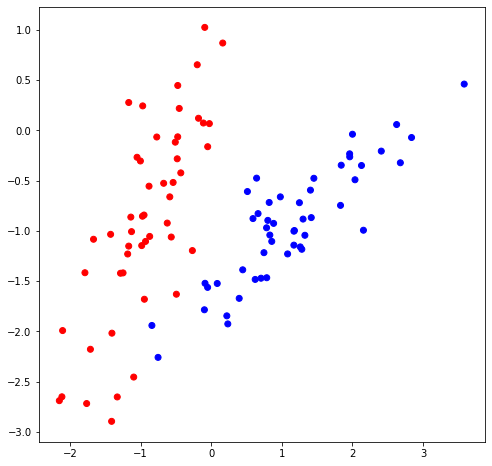

In [187]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [188]:
# Класс узла
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение в пороговом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [189]:
# Класс терминального узла(лист)
class LeafClassifier:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}

        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [190]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [191]:
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** np.log2(p)

    return impurity

In [192]:
# Расчет качества
def quality(left_labels, right_labels, current_criterion, criterion):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_criterion - p * calc_criterion(left_labels) - (1 - p) * calc_criterion(right_labels)

In [193]:
def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [194]:
def find_best_split(data, labels, criterion):
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    current_criterion = calc_criterion(labels, criterion)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_criterion, criterion)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [195]:
def fit(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, LeafClassifier):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return fit(obj, node.true_branch)
    else:
        return fit(obj, node.false_branch)

In [196]:
def predict(data, tree):
    predictions = []
    for obj in data:
        prediction = fit(obj, tree)
        predictions.append(prediction)
    return predictions

In [197]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### 5.1. Критерий останова max_depth с критерием Джини

In [198]:
def calc_criterion(labels, criterion='gini'):
    if criterion == 'gini':
        return gini(labels)
    elif criterion == 'entropy':
        return entropy(labels)
    else:
        raise Exception('Undefined criterion')

In [199]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth, criterion='gini'):

    count_depth = max_depth 
    
    while count_depth != 0:
        
        quality, t, index = find_best_split(data, labels, criterion=criterion)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качествe
        if quality == 0:
            return LeafClassifier(data, labels)
        
        #Критерий останова(глубина)
        if count_depth == 0:
            return LeafClassifier(data, labels)
    
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, max_depth)
        false_branch = build_tree(false_data, false_labels, max_depth)

        count_depth -= 1

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [200]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [201]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=5, criterion='gini')

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [202]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [203]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

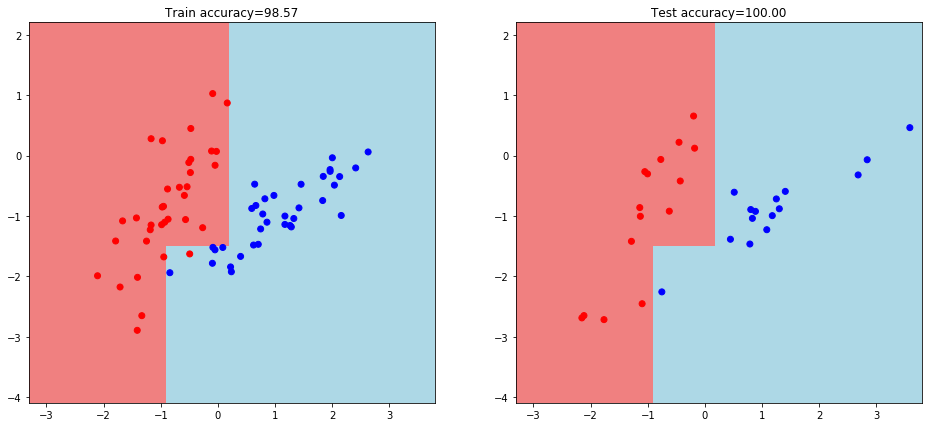

In [204]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}');

### 5.2. Дерево-классификатор с критерием энтропии

In [205]:
def calc_criterion(labels, criterion='entropy'):
    if criterion == 'gini':
        return gini(labels)
    elif criterion == 'entropy':
        return entropy(labels)
    elif criterion == 'variance':
        return variance(labels)
    else:
        raise Exception('Undefined criterion')

In [206]:
def build_tree(data, labels, max_depth, criterion='entropy'):

    count_depth = max_depth 
    
    while count_depth != 0:
        
        quality, t, index = find_best_split(data, labels, criterion=criterion)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качествe
        if quality == 0:
            return LeafClassifier(data, labels)
        
        #Критерий останова(глубина)
        if count_depth == 0:
            return LeafClassifier(data, labels)
    
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, max_depth)
        false_branch = build_tree(false_data, false_labels, max_depth)

        count_depth -= 1

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [207]:
my_tree = build_tree(train_data, train_labels, max_depth=5, criterion='entropy')
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [208]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [209]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

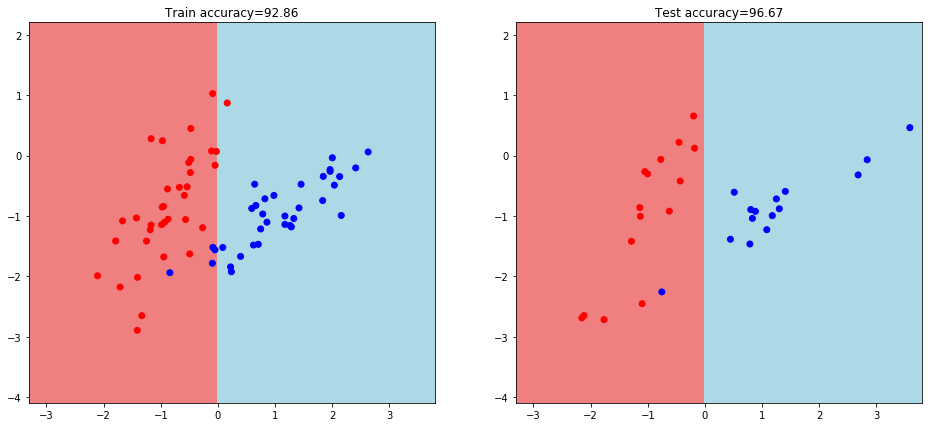

In [210]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}');

Значение меньше, чем у критерия Джини примерно на 3 п.п. Метрика на тесте также выше, скорее всего из-за синтетической природы
данных.

### 5.3. Дерево регрессор

In [211]:
data, labels, coef = datasets.make_regression(n_samples=1000, n_features = 3, n_informative = 2, n_targets = 1, 
                                              noise = 5, coef = True, random_state = 42)

In [212]:
#Лист - регрессор
class LeafRegressor:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)

In [213]:
def variance(labels):
    return np.var(labels)

In [214]:
def build_tree(data, labels, max_depth, criterion='entropy'):

    count_depth = max_depth 
    
    while count_depth != 0:
        
        quality, t, index = find_best_split(data, labels, criterion=criterion)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качествe
        if quality == 0:
            return LeafClassifier(data, labels)
        
        #Критерий останова(глубина)
        if count_depth == 0:
            return LeafClassifier(data, labels)
    
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, max_depth)
        false_branch = build_tree(false_data, false_labels, max_depth)

        count_depth -= 1

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [215]:
def calc_criterion(labels, criterion='variance'):
    if criterion == 'gini':
        return gini(labels)
    elif criterion == 'entropy':
        return entropy(labels)
    elif criterion == 'variance':
        return variance(labels)
    else:
        raise Exception('Undefined criterion')

In [216]:
train_data, test_data, train_target, test_target = model_selection.train_test_split(data, 
                                                                                     target, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [218]:
my_tree = build_tree(train_data, train_target, max_depth=5, criterion='variance')

In [219]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)

In [230]:
from sklearn.metrics import mean_squared_error

In [231]:
mean_squared_error(train_target, train_answers)

25491.929440595235

In [232]:
mean_squared_error(test_target, answers)

27210.284292595374